# Titanic: Machine Learning from Disaster

## Kaggle competition to predict survivors on the Titanic


![title](./Cd51-1000g.gif)  
![title](./Titanic_Deckplans_B_Deck.png)  


### Introduction

This Python3 project is used to predict survivors on the Titanic using machine learning techniques based on training and testing data provided by Kaggle (https://www.kaggle.com/c/titanic).

### Description

The workflow for this project is the following:
- Importing train and test data files into pandas dataframes
- Feature engineering, including:
    - Merging both the train and test dataframes to detect common patterns
    - Creating dummy variables for categorical variables (Sex, Embarked)
    - Adding new features: 
        - the fraction of survivors among the group sharing the same ticket
        - the fraction of survivors among sibblings
        - checking if the cabin is known (double the survival rate for 2nd and 3rd class passengers)
        - binning age categories ("Missing", "Infant", "Child", "Teenager", "Young Adult" ,"Adult" ,"Senior" --> also not used as a feature because it is not better than age)
        - Use of publicly available deck maps of the Titanic to determine the location of passenger cabins, including:
           - Deck (A to F)
           - Position (forward, amidships or aft)
           - Ship side (port or starboard)
           - Distance to main staircases (near or far)
    - Filling "Age" column with best estimate data (not used because it leads to overfitting training data)
        - average age of siblings, or
        - average age of other passengers with same class and sex (if available)
    - Separating the train and test dataframes again
- Quick analysis of the performance of various machine learning algorithms (Logistic regression, K-nearest , Decision tree, Random forest, Gradient boosting, Support vector machine, Naive Bayes model accuracy)
    - The best performing algorithms are random forest and gradient boosting with cross validation score of around 82% +- 4% (95% confidence interval)
- Grid search for optimization of hyperparameters for both the random forest and gradient boosting algorithms
    - Leads to slight improvement in cross validation score (84% +- 4%) with possible risk for overfitting the training data
- Predictions using the best random forest model on the testing data provided by Kaggle with 80.8% accuracy (top  7% in Kaggle's Titanic competition)
- Stacked model of the best perfroming models (random forest, gradient boosting, neural network, logistic regression)

### Main results

The best algorithm (random forest with limited features) has obtained a 80.8% accuracy on Kaggle's Titanic survivors competition (top 7%). The maximum cross validation accuracy achieved using the data is 85.4% (using the optimized gradient boosting model). The minimum possible accuracy (obtained with the assumption that every passenger on board died) is around 68%.

Below is the confusion matrix for the training data (using cross-validation) for the model with the maximum . It shows that the accuracy (85.4%), predicted positive value (i.e. probability of survival if predicted survived, 86.1%) and predicted negative value (i.e. probability did not survived if predicted did not survive, 85.1%) are all similar. 

![title](./Results_accuracy.png)  

The chart below displays the survival probability predicted by the best model (optimized gradient boosting model) for the group of passengers that did and did not survive, with distinct colors for male and female passengers and for both the training and validation dataset. It shows that, despite overfitting by the model on the training data (see high accuracy values), the model is able to predict male and female survival rate with a similar accuracy.

![title](./Predictions_sex.png)

The same chart for the "known cabin" feature (i.e. if the passenger's cabin is known in the dataset) shows that the accuracy for predicting survival of passengers with a known cabin is much lower than that of other passengers. This behavior is probably due to model overfit caused by the large number of features based on the cabin information and  low number of known passenger cabins.

![title](./Predictions_cabin.png)

This behavior may explain why the models with the highest CV accuracy did not lead to the highest leaderboard accuracy.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns', 500)

In [3]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

In [4]:
# Concatenation of training and test datasets:
train["train_test"] = 1
test["train_test"] = 0
train_test = pd.concat([train, test])

train_test.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,train_test
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,1
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,1
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1


# Feature engineering


#### Identification of passenger's last name


In [5]:
def find_last_name(row):
    return str(row["Name"]).split(",")[0]
train_test["Last_name"] = train_test.apply(find_last_name, axis =1)

print(train_test["Last_name"].value_counts().head())
train_test[(train_test["Last_name"] == "Andersson")]

Sage         11
Andersson    11
Goodwin       8
Asplund       8
Davies        7
Name: Last_name, dtype: int64


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,train_test,Last_name
13,39.0,NaN,S,31.2750,"Andersson, Mr. Anders Johan",5,14,3,male,1,0.0,347082,1,Andersson
68,17.0,NaN,S,7.9250,"Andersson, Miss. Erna Alexandra",2,69,3,female,4,1.0,3101281,1,Andersson
119,2.0,NaN,S,31.2750,"Andersson, Miss. Ellis Anna Maria",2,120,3,female,4,0.0,347082,1,Andersson
146,27.0,NaN,S,7.7958,"Andersson, Mr. August Edvard (""Wennerstrom"")",0,147,3,male,0,1.0,350043,1,Andersson
541,9.0,NaN,S,31.2750,"Andersson, Miss. Ingeborg Constanzia",2,542,3,female,4,0.0,347082,1,Andersson
542,11.0,NaN,S,31.2750,"Andersson, Miss. Sigrid Elisabeth",2,543,3,female,4,0.0,347082,1,Andersson
610,39.0,NaN,S,31.2750,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",5,611,3,female,1,0.0,347082,1,Andersson
813,6.0,NaN,S,31.2750,"Andersson, Miss. Ebba Iris Alfrida",2,814,3,female,4,0.0,347082,1,Andersson
850,4.0,NaN,S,31.2750,"Andersson, Master. Sigvard Harald Elias",2,851,3,male,4,0.0,347082,1,Andersson
214,38.0,NaN,S,7.7750,"Andersson, Miss. Ida Augusta Margareta",2,1106,3,female,4,NaN,347091,0,Andersson


#### Calculation of family size

In [6]:
def family_size(df):
    return df["Parch"] + df["SibSp"] + 1

train_test["Family_size"] = family_size(train_test)
train_test["Family_size"].value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family_size, dtype: int64

#### Fraction of group (i.e. sharing same ticket) that survived

In [7]:
def fraction_group_survived(df):
    fraction_group_survived_list = []
    for index, row in df.iterrows():
        group_df = df[(df["Ticket"] == row["Ticket"]) & (df["PassengerId"] != row["PassengerId"])]
        group_df = group_df.dropna(subset = ["Survived"])
        if len(group_df) >= 1:
            fraction_survived = len(group_df[group_df["Survived"] == 1]) / len(group_df)
        else:
            fraction_survived = -1
        fraction_group_survived_list.append(fraction_survived)
    return fraction_group_survived_list

train_test["Fraction_group_survived"] = fraction_group_survived(train_test)
print(train_test["Fraction_group_survived"].value_counts())

-1.000000    813
 1.000000    219
 0.000000    202
 0.500000     40
 0.666667     21
 0.333333      7
 0.750000      4
 0.833333      2
 0.714286      1
Name: Fraction_group_survived, dtype: int64


#### Fraction of sibling (i.e. sharing same last name and same number of siblings) that survived

In [8]:
def fraction_siblings_survived(df):
    fraction_siblings_survived_list = []
    for index, row in df.iterrows():
        if row["SibSp"] >=1:
            siblings_df = df[(df["Last_name"] == row["Last_name"]) & (df["SibSp"] == row["SibSp"]) & (df["PassengerId"] != row["PassengerId"])]
            siblings_df = siblings_df.dropna(subset = ["Survived"])
            if len(siblings_df) >= 1:
                fraction_survived = len(siblings_df[siblings_df["Survived"] == 1]) / len(siblings_df)
            else:
                fraction_survived = -1
        else:
            fraction_survived = -1
        fraction_siblings_survived_list.append(fraction_survived)
    return fraction_siblings_survived_list
    
train_test["Fraction_siblings_survived"] = fraction_siblings_survived(train_test)
print(train_test["Fraction_siblings_survived"].value_counts())

-1.000000    1029
 0.000000     140
 1.000000     110
 0.500000      12
 0.666667       5
 0.200000       5
 0.600000       4
 0.800000       2
 0.166667       1
 0.333333       1
Name: Fraction_siblings_survived, dtype: int64


#### Filling "Age" and "Fare" columns with best estimate data

In [9]:
def fill_age(df):
    list_age = []
    for index, row in df.iterrows():
        if not np.isnan(row["Age"]):
            age = row["Age"]
        else:
            # If age is missing, then average value of passengers of same sex and class
            cat_Pclass = (df["Pclass"] == row["Pclass"])
            cat_Sex = (df["Sex"] == row["Sex"])
            age = df[cat_Pclass & cat_Sex]["Age"].mean()
            # If has siblings, then age is average value of siblings
            if row["SibSp"] >= 1:
                siblings_df = df[(df["Last_name"] == row["Last_name"]) & (df["SibSp"] == row["SibSp"]) & (df["PassengerId"] != row["PassengerId"])]
                if not np.isnan(siblings_df["Age"].mean()):
                    age = siblings_df["Age"].mean()
        list_age.append(round(age))
    return list_age

def fill_fare(df):
    list_fare = []
    for index, row in df.iterrows():
        if not np.isnan(row["Fare"]):
            fare = row["Fare"]
        else:
            cat_Pclass = (df["Pclass"] == row["Pclass"])
            fare = df[cat_Pclass]["Fare"].mean() * row["Family_size"]
        list_fare.append(fare)
    return list_fare

train_test["Age_filled"] = fill_age(train_test)
train_test["Age"] = train_test["Age"].fillna(-1)

train_test["Fare"] = fill_fare(train_test)

#### Creating age categories

In [10]:
cut_points = [-2,0,5,12,18,35,60,100]
label_names = ["Missing", "Infant", "Child", "Teenager", "Young Adult" ,"Adult" ,"Senior"]
train_test["Age_categories"] = pd.cut(train_test["Age"],cut_points,labels=label_names)
train_test["Age_categories"].value_counts()

Young Adult    531
Adult          289
Missing        263
Teenager        99
Infant          56
Child           38
Senior          33
Name: Age_categories, dtype: int64

#### Adding feature to indicate that passenger cabin is known:

In [11]:
# Add feature to indicate that passenger cabin is known:
train_test.loc[train_test["Cabin"].notnull(), "Known_cabin"] = 1
train_test.loc[train_test["Cabin"].isnull(), "Known_cabin"] = 0
train_test["Known_cabin"].value_counts()

0.0    1014
1.0     295
Name: Known_cabin, dtype: int64

#### Deck and cabin location using deck maps of the Titanic

The following features have been added using publicly available deck maps of the Titanic (see https://www.encyclopedia-titanica.org/titanic-deckplans/a-deck.html):
- deck (A to F),
- Position (forward, amidships or aft),
- Ship side (port or starboard), with even cabin number generaly on port side
- Distance to main staircases (near or far)

Example of Titanic deck plan (B deck):

![title](./Titanic Deckplans B Deck.png)  


In [12]:
deck_list = []
room_list = []
position_ship_list = []
side_ship_list = []
distance_staircase_list = []

for cabin in train_test["Cabin"]:

    deck = np.NaN
    room = np.NaN
    position_ship = np.NaN
    side_ship = np.NaN
    distance_staircase = np.NaN
    side_ship = np.NaN
    
    if (type(cabin) != float) or (not np.isnan(cabin)):
        cabin = cabin.split(" ")[-1]
        deck = cabin[0]
        room = cabin[1:]
        if room != "":
            room = int(room)
            # For each deck
            if deck == "A":
                # Position on the ship
                position_ship = "forward"
                # Distance to main staircases
                if room >= 22:
                    distance_staircase = "close"
                else:
                    distance_staircase = "far"
            # Side of the ship
                if room % 2 == 0:
                    side_ship = "port"
                else:
                    side_ship = "starboard"

            
            if deck == "B":
                # Position on the ship
                if room <= 49:
                    position_ship = "forward"
                else:
                    position_ship = "amidships"
                # Distance to main staircases    
                if ((room >= 30) and (room <= 56)) or (room >= 87): 
                    distance_staircase = "close"
                else:
                    distance_staircase = "far"
                # Side of the ship
                if room % 2 == 0:
                    side_ship = "port"
                else:
                    side_ship = "starboard"       
                    
            if deck == "C":
                # Position on the ship
                forward_rooms = list(range(2,62,2)) + list(range(1,55,2))
                amidships_rooms = list(range(62,92,2)) + list(range(55,85,2)) + list(range(104,142,2)) + list(range(95,123,2))
                close_rooms = list(range(32,48,2)) + list(range(33,41,2)) + [62, 64, 95, 97, 104, 106] + list(range(88,96,2)) + list(range(142,146,2)) + list(range(81,91,2)) + [123,125,142,144] 
                if room in forward_rooms:
                    position_ship = "forward"
                
                elif room in amidships_rooms:
                    position_ship = "amidships"
                else:
                    position_ship = "aft"
                # Distance to main staircases    
                if room in close_rooms: 
                    distance_staircase = "close"
                else:
                    distance_staircase = "far"
                # Side of the ship
                if room % 2 == 0:
                    side_ship = "port"
                else:
                    side_ship = "starboard"
                
            if deck == "D":
                # Position on the ship
                forward_rooms = list(range(1,51))
                amidships_rooms = []
                close_rooms = list(range(30,38)) + [52,58,56,62,51,57,55,61] + list(range(127,131))
                if room in forward_rooms:
                    position_ship = "forward"
                elif room in amidships_rooms:
                    position_ship = "amidships"
                else:
                    position_ship = "aft"
                # Distance to main staircases    
                if room in close_rooms: 
                    distance_staircase = "close"
                else:
                    distance_staircase = "far"
                # Side of the ship    
                if room % 2 == 0:
                    side_ship = "port"
                else:
                    side_ship = "starboard"
                    
            if deck == "E":
                # Position on the ship
                forward_rooms = list(range(1,30)) + list(range(200, 204))
                amidships_rooms = list(range(30,77))
                close_rooms = list(range(1,9)) + list(range(200, 204)) + list(range(26,34)) + list(range(82,98))
                port_rooms = []
                if room in forward_rooms:
                    position_ship = "forward"
                elif room in amidships_rooms:
                    position_ship = "amidships"
                else:
                    position_ship = "aft"
                # Distance to main staircases    
                if room in close_rooms: 
                    distance_staircase = "close"
                else:
                    distance_staircase = "far"
               # Side of the ship     
                if room in port_rooms:
                    side_ship = "port"
                else:
                    side_ship = "starboard"
                    
            if deck == "F":
                # Position on the ship
                forward_rooms = []
                amidships_rooms = []
                close_rooms = list(range(20,32,2)) + list(range(15,39,2)) + list(range(51,67,2)) + list(range(50,62,2))
                if room in forward_rooms:
                    position_ship = "forward"
                elif room in amidships_rooms:
                    position_ship = "amidships"
                else:
                    position_ship = "aft"
                # Distance to main staircases    
                if room in close_rooms: 
                    distance_staircase = "close"
                else:
                    distance_staircase = "far"
                # Side of the ship    
                if room % 2 == 0:
                    side_ship = "port"
                else:
                    side_ship = "starboard"
                    
            if deck == "G":
                # Position on the ship
                forward_rooms = []
                amidships_rooms = []
                close_rooms = list(range(2,32,2)) + [1, 3, 11, 19]
                if room in forward_rooms:
                    position_ship = "forward"
                elif room in amidships_rooms:
                    position_ship = "amidships"
                else:
                    position_ship = "aft"
                # Distance to main staircases    
                if room in close_rooms: 
                    distance_staircase = "close"
                else:
                    distance_staircase = "far"
                # Side of the ship    
                if room % 2 == 0:
                    side_ship = "port"
                else:
                    side_ship = "starboard"
                    
            print(deck, room, position_ship, distance_staircase, side_ship)
   
    deck_list.append(deck)
    room_list.append(room)        
    position_ship_list.append(position_ship)
    side_ship_list.append(side_ship)
    distance_staircase_list.append(distance_staircase)
    
train_test["Deck"] =deck_list
train_test["Room"] = room_list
train_test["Position_ship"] = position_ship_list
train_test["Side_ship"] = side_ship_list
train_test["Distance_staircase"] = distance_staircase_list


C 85 aft close starboard
C 123 aft close starboard
E 46 amidships far starboard
G 6 aft close port
C 103 amidships far starboard
D 56 aft close port
A 6 forward far port
C 27 forward far starboard
B 78 amidships far port
D 33 forward close starboard
B 30 forward close port
C 52 forward far port
B 28 forward far port
C 83 amidships close starboard
F 33 aft close starboard
G 73 aft far starboard
C 27 forward far starboard
E 31 amidships close starboard
A 5 forward far starboard
D 12 forward far port
D 26 forward far port
C 110 amidships far port
B 60 amidships far port
E 101 aft far starboard
D 26 forward far port
E 69 amidships far starboard
D 47 forward far starboard
C 123 aft close starboard
B 86 amidships far port
F 2 aft far port
C 2 forward far port
E 33 amidships close starboard
B 19 forward far starboard
A 7 forward far starboard
C 49 forward far starboard
F 4 aft far port
A 32 forward close port
F 2 aft far port
B 4 forward far port
B 80 amidships far port
G 6 aft close port
A 3

#### Creating dummy variables for categorical features:

In [13]:
# Creating dummy variables for categorical features:
dummy = pd.get_dummies(train_test[["Sex", "Embarked", "Age_categories", "Deck", "Position_ship", "Side_ship", "Distance_staircase"]])
train_test = pd.concat([train_test, dummy], axis = 1)

# Data visualization

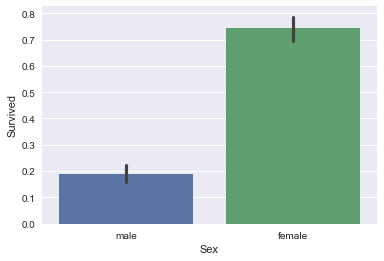

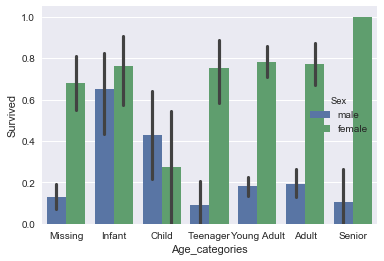

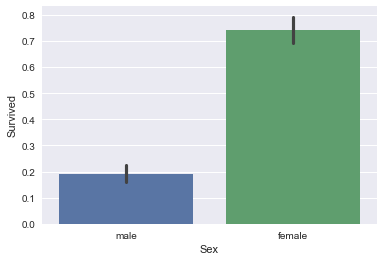

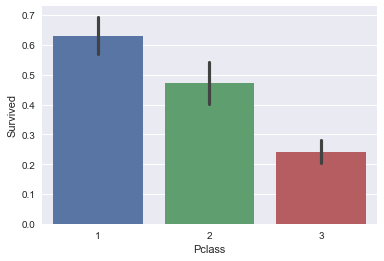

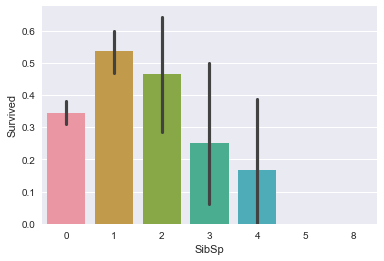

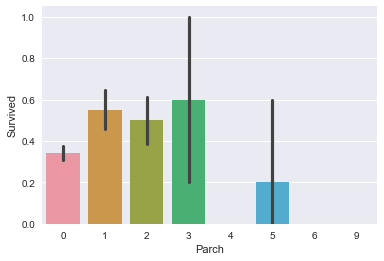

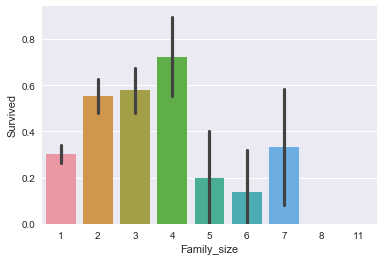

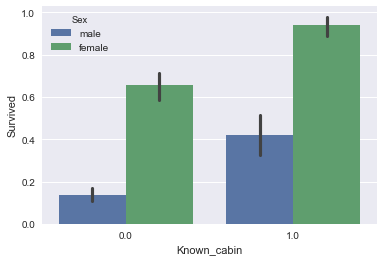

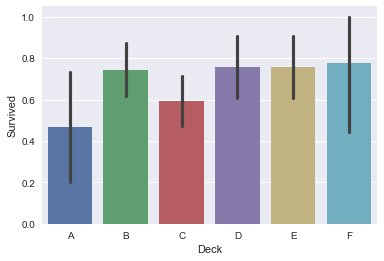

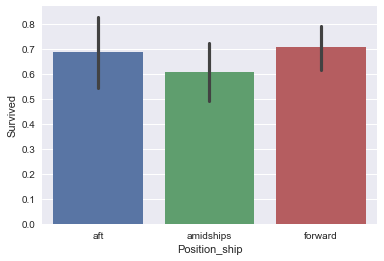

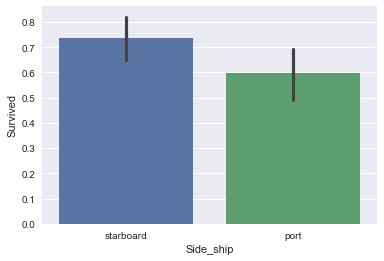

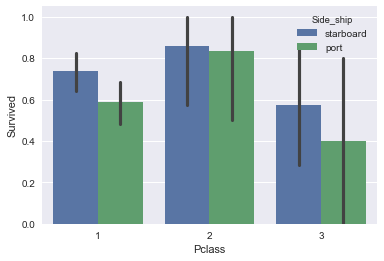

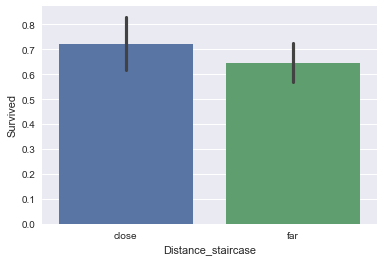

In [14]:
import seaborn as sns

sns.set()

sns.barplot(x="Sex", y="Survived", data=train_test)
plt.show()

sns.barplot(x="Age_categories", y="Survived", hue = "Sex", data=train_test)
plt.show()

sns.barplot(x="Sex", y="Survived", data=train_test)
plt.show()

sns.barplot(x="Pclass", y="Survived", data=train_test)
plt.show()

sns.barplot(x="SibSp", y="Survived", data=train_test)
plt.show()

sns.barplot(x="Parch", y="Survived", data=train_test)
plt.show()

sns.barplot(x="Family_size", y="Survived", data=train_test)
plt.show()

sns.barplot(x="Known_cabin", y="Survived", hue = "Sex", data=train_test)
plt.show()

sns.barplot(x="Deck", y="Survived", data=train_test, order=["A", "B", "C", "D", "E", "F"])
plt.show()

sns.barplot(x="Position_ship", y="Survived", data=train_test)
plt.show()

sns.barplot(x="Side_ship", y="Survived", data=train_test)
plt.show()

sns.barplot(x="Pclass", y="Survived", hue = "Side_ship", data=train_test)
plt.show()

sns.barplot(x="Distance_staircase", y="Survived", data=train_test)
plt.show()

# Machine learning models

#### Splitting back the train and test dataframes

In [15]:
train = train_test[train_test["train_test"] == 1]
test = train_test[train_test["train_test"] == 0]

#### First exploration of main maching learning models performance

In [16]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

features = ["Pclass", "Sex_female", "SibSp", "Age_filled", "Parch", "Fare", "Embarked_C", "Embarked_S", \
            "Fraction_group_survived", "Fraction_siblings_survived", "Known_cabin"] + \
            ["Embarked_C", "Embarked_Q", "Embarked_S", "Age_categories_Missing","Age_categories_Infant",\
             "Age_categories_Child","Age_categories_Teenager","Age_categories_Young Adult",\
             "Age_categories_Adult","Age_categories_Senior","Deck_A","Deck_B","Deck_C","Deck_D",\
             "Deck_E","Deck_F","Deck_G","Position_ship_aft","Position_ship_amidships",\
             "Position_ship_forward","Side_ship_port","Side_ship_starboard", "Distance_staircase_close",\
             "Distance_staircase_far", "Family_size"]
target = "Survived"

random_state = 1
lr = LogisticRegression()
scores_lr = cross_val_score(lr, train[features], train[target], cv=5)
print("Logistic regression model accuracy: %0.2f (+/- %0.2f)" % (scores_lr.mean(), scores_lr.std() * 2))

random_state = 1
kn = KNeighborsClassifier(n_neighbors = 4, weights = "distance")
scores_kn = cross_val_score(kn, train[features], train[target], cv=5)
print("K-nearest neighbors model accuracy: %0.2f (+/- %0.2f)" % (scores_kn.mean(), scores_kn.std() * 2))

random_state = 1
dt = DecisionTreeClassifier()
scores_dt = cross_val_score(dt, train[features], train[target], cv=5)
print("Decision tree model accuracy: %0.2f (+/- %0.2f)" % (scores_dt.mean(), scores_dt.std() * 2))

random_state = 1
rf = RandomForestClassifier(random_state = 42)
scores_rf = cross_val_score(rf, train[features], train[target], cv=5)
print("Random forest model accuracy: %0.2f (+/- %0.2f)" % (scores_rf.mean(), scores_rf.std() * 2))

random_state = 1
gb =GradientBoostingClassifier(random_state = 42)
scores_gb = cross_val_score(gb, train[features], train[target], cv=5)
print("Gradient boosting model accuracy: %0.2f (+/- %0.2f)" % (scores_gb.mean(), scores_gb.std() * 2))

random_state = 1
sv =SVC(kernel ="linear")
scores_sv = cross_val_score(sv, train[features], train[target], cv=5)
print("Support vector machine model accuracy: %0.2f (+/- %0.2f)" % (scores_sv.mean(), scores_sv.std() * 2))

random_state = 1
nb = GaussianNB()
scores_nb = cross_val_score(nb, train[features], train[target], cv=5)
print("Naive Bayes model accuracy: %0.2f (+/- %0.2f)" % (scores_nb.mean(), scores_nb.std() * 2))

random_state = 1
nn = MLPClassifier(hidden_layer_sizes=(20), activation = "tanh", alpha =0.1, random_state = 42)
scores_nn = cross_val_score(nn, train[features], train[target], cv=5)
print("Neural network model accuracy: %0.2f (+/- %0.2f)" % (scores_nn.mean(), scores_nn.std() * 2))

Logistic regression model accuracy: 0.81 (+/- 0.02)
K-nearest neighbors model accuracy: 0.71 (+/- 0.05)
Decision tree model accuracy: 0.81 (+/- 0.05)
Random forest model accuracy: 0.81 (+/- 0.07)
Gradient boosting model accuracy: 0.85 (+/- 0.03)
Support vector machine model accuracy: 0.81 (+/- 0.03)
Naive Bayes model accuracy: 0.72 (+/- 0.08)
Neural network model accuracy: 0.79 (+/- 0.06)


#### Conclusions
This quick exploration shows that the most accurate machine learning models for this problem are:
- Gradient boosting: 0.85 (+/- 0.03)
- Random forest: 0.81 (+/- 0.07)
- Support vector machine: 0.81 (+/- 0.03)
- Logistic regression: 0.81 (+/- 0.02)
- Neural network: 0.79 (+/- 0.06)

#### Winning algorithm : random forest model with limited features

In [17]:
# Parameters for grid search CV
parameters_rf = {"n_estimators": [1000],
                 "max_features": ["sqrt"],
                 "max_depth": [4, 5, 6, 7],
                 "min_samples_split": [3, 4, 5]
                }
rf = RandomForestClassifier(random_state = 42, n_jobs = -1)
gs_rf = GridSearchCV(rf, parameters_rf, cv=5)

In [18]:
features_rf = ["Pclass", "Sex_female", "Age", "SibSp", "Parch", "Fare", "Embarked_C", "Embarked_S", "Fraction_group_survived", "Fraction_siblings_survived", "Known_cabin"]
target = "Survived"
gs_rf.fit(train[features_rf], train[target])
print(gs_rf.best_params_)
print(gs_rf.best_score_)

{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 1000}
0.830527497194


Best random forest model accuracy: 0.831 (+/- 0.054)


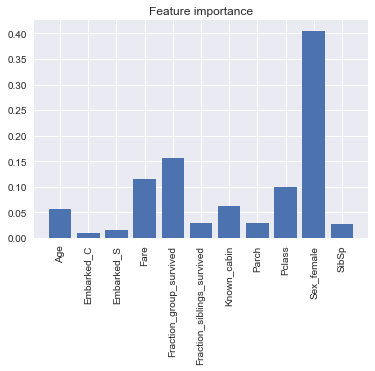

In [19]:
best_rf = gs_rf.best_estimator_
scores_best_rf = cross_val_score(best_rf, train[features_rf], train[target], cv=5)
print("Best random forest model accuracy: %0.3f (+/- %0.3f)" % (scores_best_rf.mean(), scores_best_rf.std() * 2))

plt.bar(features_rf, best_rf.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importance")
plt.show()

In [20]:
predictions = best_rf.predict(test[features_rf]).astype(int)

predictions_id = test["PassengerId"]
submission_df = {"PassengerId": predictions_id,
                 "Survived": predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv("./data/gender_submission.csv",index=False)

#### Results:

This is my best scoring model for the Kaggle competition, with a CV accuracy of 0.831 (+/- 0.054) and a Kaggle leaderboard score of 0.80861.

Compared to other models below, this model has a lower CV accuracy but a higher Kaggle leaderboard score, so this could be due to chance (or overfitting the leaderboard).

#### Optimized random forest model with all features

In [21]:
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split

rf2 = RandomForestClassifier(random_state = 42, n_jobs = -1, n_estimators=1000)

param = {}
param["max_depth"] = (1, 20)
param["max_features"] = (1, 20)
param["min_samples_split"] = (2, 200)

bayes_opt = BayesSearchCV(cv=5, estimator = rf2, search_spaces = param, n_iter=32, scoring="accuracy")

bayes_opt.fit(train[features], train[target])

print("val. score: %s" % bayes_opt.best_score_)
print(bayes_opt.best_params_)

val. score: 0.83950617284
{'max_depth': 11, 'max_features': 20, 'min_samples_split': 2}


In [22]:
# Parameters for grid search CV
parameters_rf2 = {"n_estimators": [1000],
                 "max_features": [19],
                 "max_depth": [14],
                 "min_samples_split": [9]
                }
rf2 = RandomForestClassifier(random_state = 42, n_jobs = -1)
gs_rf2 = GridSearchCV(rf2, parameters_rf2, cv=10)
gs_rf2.fit(train[features], train[target])
print(gs_rf2.best_params_)
print(gs_rf2.best_score_)

{'max_depth': 14, 'max_features': 19, 'min_samples_split': 9, 'n_estimators': 1000}
0.846240179574


Best random forest model accuracy: 0.845 (+/- 0.050)


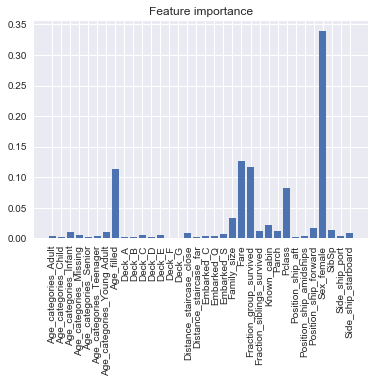

In [23]:
best_rf_opt = gs_rf2.best_estimator_
scores_best_rf = cross_val_score(best_rf_opt, train[features], train[target], cv=5)
print("Best random forest model accuracy: %0.3f (+/- %0.3f)" % (scores_best_rf.mean(), scores_best_rf.std() * 2))

plt.bar(features, best_rf_opt.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importance")
plt.show()

In [24]:
predictions = best_rf_opt.predict(test[features]).astype(int)

predictions_id = test["PassengerId"]
submission_df = {"PassengerId": predictions_id,
                 "Survived": predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv("./data/gender_submission.csv",index=False)

#### Results:

This random forest model optimized with bayesian optimization and gridsearch has a CV accuracy of 0.845 (+/- 0.050) and a Kaggle leaderboard score of only 0.78468.

This large discrepency between the CV and leaderboard accuracy probably shows that the Kaggle test subset (on which the leaderboard score is calculated) has  not been selected randomly from the training dataset (p\<0.05) or that the optimization of the model's hyperparameters leads to overfit the validation data during CV.

The analysis of feature importance shows that the most important features are sex, age, fare, passenger class and fraction of group that survived. Most ship position features are not very important, likely because the cabin is missing for most passengers.

#### Optimized gradient boosting model with all features

In [25]:
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split

gb = GradientBoostingClassifier(random_state = 42)

param = {}
param["n_estimators"] = (10, 500)
param["max_depth"] = (1, 20)
param["min_samples_split"] = (2, 40)
param["subsample"] = (0.2, 1.0, "log-uniform")
param["learning_rate"] = (0.02, 0.1, "log-uniform")


bayes_opt = BayesSearchCV(cv=5, estimator = gb, search_spaces = param, n_iter=32, scoring="accuracy")

bayes_opt.fit(train[features], train[target])

print("val. score: %s" % bayes_opt.best_score_)
print(bayes_opt.best_params_)

val. score: 0.841750841751
{'learning_rate': 0.055108000492589591, 'max_depth': 15, 'min_samples_split': 24, 'n_estimators': 36, 'subsample': 0.92547203680565759}


In [26]:
parameters_gb = {"n_estimators": [290],
                 "max_depth": [4],
                 "min_samples_split": [4],
                 "subsample": [1.0],
                 "learning_rate": [0.02]
                }

gb = GradientBoostingClassifier(random_state = 42)
gs_gb = GridSearchCV(gb, parameters_gb, cv=5)
gs_gb.fit(train[features], train[target])
print(gs_gb.best_params_)
print(gs_gb.best_score_)

{'learning_rate': 0.02, 'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 290, 'subsample': 1.0}
0.854096520763


Best gradient boosting model accuracy: 0.854 (+/- 0.048)


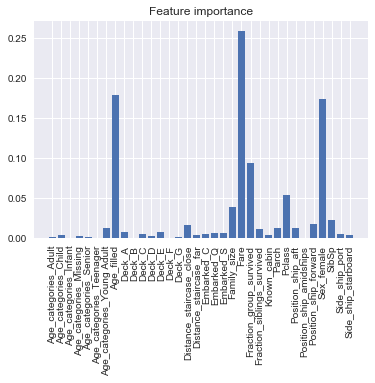

In [27]:
best_gb = gs_gb.best_estimator_
scores_best_gb = cross_val_score(best_gb, train[features], train[target], cv=5)
print("Best gradient boosting model accuracy: %0.3f (+/- %0.3f)" % (np.mean(scores_best_gb), np.std(scores_best_gb) * 2))

plt.bar(features, best_gb.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importance")
plt.show()

In [28]:
predictions = best_gb.predict(test[features]).astype(int)

predictions_id = test["PassengerId"]
submission_df = {"PassengerId": predictions_id,
                 "Survived": predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv("./data/gender_submission.csv",index=False)

#### Results:

This gradient boosting model optimized with gridsearch has a CV accuracy of 0.854 (+/- 0.048) but a Kaggle leaderboard score of only 0.78947.

Once again, there is a large discrepency between the training CV and the test leaderboard score.

The analysis of feature importance shows that the most important features are once again fare, sex, age, fare, passenger class and fraction of group that survived.

#### Stacked model using best performing models
This random forest model uses probability predictions from previous models (gradient boosting, random forest,  logistic regression and neural network) in order to create a more robust model.

In [29]:
# Optimization of neural network model

parameters_nn = {"hidden_layer_sizes": [(15,5)],
                 "alpha": [0.2],
                 "activation": ["tanh"]
                }

nn = MLPClassifier()
gs_nn = GridSearchCV(nn, parameters_nn, cv=5)
gs_nn.fit(train[features], train[target])
print(gs_nn.best_params_)
print(gs_nn.best_score_)

{'activation': 'tanh', 'alpha': 0.2, 'hidden_layer_sizes': (15, 5)}
0.796857463524


In [48]:
# Optimization of support vector machine

parameters_sv = {"kernel": ["linear"],
                 "C": [0.5],
                 "gamma": ["auto"]
                }
sv = SVC(probability = True)
gs_sv = GridSearchCV(sv, parameters_sv, cv=5)
gs_sv.fit(train[features], train[target])
print(gs_sv.best_params_)
print(gs_sv.best_score_)

{'C': 0.5, 'gamma': 'auto', 'kernel': 'linear'}
0.811447811448


In [31]:
# Optimization of logistic regression model

parameters_lr = {"C": [0.5],
                }
lr = LogisticRegression()
gs_lr = GridSearchCV(lr, parameters_lr, cv=5)
gs_lr.fit(train[features], train[target])
print(gs_lr.best_params_)
print(gs_lr.best_score_) 

{'C': 0.5}
0.808080808081


In [49]:
# Calculation of survival probability for each model using CV approach 
#(for each CV iteration, the outcome predicted by the model is calculated for the validation fold 
# using the traing folds)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Initialization of series in training and testing datasets
first_level_features = ["lr_proba", "rf_proba", "gb_proba", "sv_proba", "nn_proba"]
for item in first_level_features:
    train[item] = -1.0
    test[item] = -1.0
train["stacked_model_predict"] = -1.0
test["stacked_model_predict"] = -1.0

# Cross validation predictions
kf = KFold(n_splits=5, shuffle=True)
accuracy_list = []
feature_importances_list = []
counter = 0
for train_index, val_index in kf.split(train):
    counter += 1
    print("First level model training CV"+str(counter))
    train_train = train.iloc[train_index]
    train_val = train.iloc[val_index]
    
    best_rf_opt.fit(train_train[features], train_train[target])
    train["rf_proba"].iloc[val_index] = best_rf_opt.predict_proba(train_val[features])[:,1]
    best_gb.fit(train_train[features], train_train[target])
    train["gb_proba"].iloc[val_index] = best_gb.predict_proba(train_val[features])[:,1]
    gs_nn.best_estimator_.fit(train_train[features], train_train[target])
    train["nn_proba"].iloc[val_index] = gs_nn.best_estimator_.predict_proba(train_val[features])[:,1]
    gs_sv.best_estimator_.fit(train_train[features], train_train[target])
    train["sv_proba"].iloc[val_index] = gs_sv.best_estimator_.predict_proba(train_val[features])[:,1]
    gs_lr.best_estimator_.fit(train_train[features], train_train[target])
    train["lr_proba"].iloc[val_index] = gs_lr.best_estimator_.predict_proba(train_val[features])[:,1]


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

First level model training CV1


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_

First level model training CV2


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

First level model training CV3


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

First level model training CV4


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

First level model training CV5


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum itera

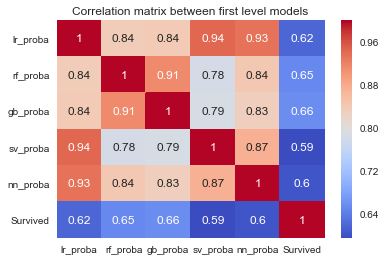

In [51]:
# Analysis of correlation between prediction features
corr = train[["lr_proba", "rf_proba", "gb_proba", "sv_proba", "nn_proba", "Survived"]].corr(method = "spearman")
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values, annot=True, cmap = "coolwarm")
plt.title("Correlation matrix between first level models")
plt.show()

In [62]:
# Definition of stacked model (logistic regression)

accuracy_list = []
counter = 0
for train_index, val_index in kf.split(train):
    counter += 1
    train_train = train.iloc[train_index]
    train_val = train.iloc[val_index]
    random_state = 42
    model_stack = RandomForestClassifier(n_estimators=1000, max_features=2, max_depth=1)
    model_stack.fit(train_train[first_level_features], train_train[target])
    model_stack.predict(train_train[first_level_features])
    train["stacked_model_predict"].iloc[val_index] = model_stack.predict(train_val[first_level_features])
    accuracy = accuracy_score(train["stacked_model_predict"].iloc[val_index], train_val[target])
    print("Second level model CV"+str(counter)+ " training accuracy:", accuracy)
    accuracy_list.append(accuracy)
    
print("Stacked model accuracy: %0.3f (+/- %0.3f)" % (np.mean(accuracy_list), np.std(accuracy_list) * 2))


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Second level model CV1 training accuracy: 0.826815642458


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Second level model CV2 training accuracy: 0.859550561798


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Second level model CV3 training accuracy: 0.85393258427


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Second level model CV4 training accuracy: 0.848314606742
Second level model CV5 training accuracy: 0.825842696629
Stacked model accuracy: 0.843 (+/- 0.028)


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [64]:
# Application of stacked model to test dataset

test["rf_proba"] = best_rf_opt.predict_proba(test[features])[:,1]
test["gb_proba"] = best_gb.predict_proba(test[features])[:,1]
test["nn_proba"] = gs_nn.best_estimator_.predict_proba(test[features])[:,1]
test["sv_proba"] = gs_sv.best_estimator_.predict_proba(test[features])[:,1]
test["lr_proba"] = gs_lr.best_estimator_.predict_proba(test[features])[:,1]

model_stack = RandomForestClassifier(n_estimators=1000, max_features=2, max_depth=1)
model_stack.fit(train[first_level_features], train[target])
test["stacked_model_predict"] = model_stack.predict(test[first_level_features])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [65]:
submission_df = {"PassengerId": test["PassengerId"],
                 "Survived": test["stacked_model_predict"].astype(int)}
submission = pd.DataFrame(submission_df)
submission.to_csv("./data/gender_submission.csv",index=False)

#### Results

The stacked model taking into account the best random forest, gradient boosting, neural network and linear regression has a CV accuracy of 0.843 (+/- 0.028), which is less than some of the best models of which it is composed. Its Kaggle leaderboard score is 0.78947.

# Analyses

Below are some analyses of the predictions based on our most successful model with regards to CV score (optimized grandient boosting model).

Accuracy = 85.4%
Prediced positive value = 86.1%
Prediced negative value = 85.1%


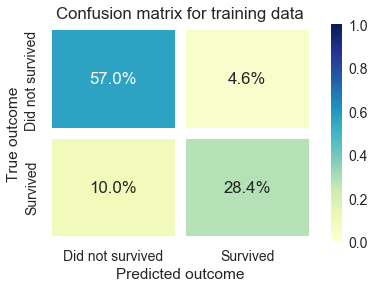

In [441]:
# Analysis of accuracy results

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

train_pred = cross_val_predict(best_gb, train[features], train[target], cv = 5)
cm = confusion_matrix(train[target], train_pred)/len(train[target])

print("Accuracy = %0.1f" % (100*(cm[0,0] + cm[1,1]))+"%")
print("Prediced positive value = %0.1f" % (100*(cm[1,1]/(cm[0,1] + cm[1,1])))+"%")
print("Prediced negative value = %0.1f" % (100*(cm[0,0]/(cm[1,0] + cm[0,0])))+"%")

#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True, fmt=".1%", cmap="YlGnBu", vmin=0, vmax=1, linewidth = 10)# font size
plt.ylabel("True outcome")
plt.xlabel("Predicted outcome")
plt.xticks([0.5, 1.5], ["Did not survived", "Survived"])
plt.yticks([0.1, 1.3], ["Did not survived", "Survived"])
plt.title("Confusion matrix for training data")
plt.show()



In [457]:
from sklearn.model_selection import train_test_split

def display_predictions(df, model, test_size, feature):
    train_train, train_val = train_test_split(df, test_size = test_size)
    list_values =sorted(df[df[feature].notnull()][feature].unique())

    pal = sns.color_palette("deep")
    if len(pal) < len(list_values):
        pal = sns.color_palette("coolwarm", len(list_values))

    model.fit(train_train[features_rf],  train_train[target])
    train_train["Predicted_proba_model"] = model.predict_proba(train_train[features_rf])[:,1]
    train_val["Predicted_proba_model"] = model.predict_proba(train_val[features_rf])[:,1]
    accuracy_train =  len(train_train[(train_train["Predicted_proba_model"].round() == train_train[target])])/len(train_train)
    accuracy_val =  len(train_val[(train_val["Predicted_proba_model"].round() == train_val[target])])/len(train_val)

    fig = plt.figure(figsize=(25,12))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    g1 = sns.stripplot(x = "Survived", y = "gb_proba", hue = feature, data = train_train, orient = "v", jitter = True, ax = ax1, hue_order = list_values, palette=pal)
    g2 = sns.stripplot(x = "Survived", y = "gb_proba", hue = feature, data = train_val, orient = "v", jitter = True, ax = ax2, hue_order = list_values, palette=pal)
    ax1.axhline(0.5, label = "Survival cutoff", color = sns.color_palette("deep").as_hex()[2])
    ax2.axhline(0.5, label = "Survival cutoff", color = sns.color_palette("deep").as_hex()[2])
    ax1.set_ylabel("Predicted probability of survival")
    ax2.set_ylabel("Predicted probability of survival")
    ax1.set_xlabel("Survival status")
    ax2.set_xlabel("Survival status")

    ax1.set_xticklabels(["Did not survive", "Survived"])
    ax2.set_xticklabels(["Did not survive", "Survived"])
    ax1.set_title("Predictions on training dataset as a function of "+feature+" (ovr. accuracy: %0.2f)" % accuracy_train)
    ax2.set_title("Predictions on validation dataset as a function of "+feature+" (ovr. accuracy: %0.2f)" % accuracy_val)
    list_labels_ax1 = [" Survival cutoff"]
    list_labels_ax2 = ["Survival cutoff"]  
    for index, item in enumerate(list_values):
        df_train = train_train[train_train[feature] == item]
        df_val = train_val[train_val[feature] == item]
        accuracy_legend_train = len(df_train[(df_train["Predicted_proba_model"].round() == df_train[target])])/len(df_train) 
        accuracy_legend_val = len(df_val[(df_val["Predicted_proba_model"].round() == df_val[target])])/len(df_val) 
        list_labels_ax1.append(str(item)+" (acc: "+str(round(accuracy_legend_train, 2))+")")
        list_labels_ax2.append(str(item)+" (acc: "+str(round(accuracy_legend_val,2))+")")
    ax1.legend(labels = list_labels_ax1)
    ax2.legend(labels = list_labels_ax2)
    # Correction of wrong color and size in legend
    for index, item in enumerate(list_values):
        ax1.legend_.legendHandles[index+1].set_color(pal.as_hex()[index])
        ax2.legend_.legendHandles[index+1].set_color(pal.as_hex()[index])
        ax1.legend_.legendHandles[index+1]._sizes = [25]
        ax2.legend_.legendHandles[index+1]._sizes = [25]
    plt.show()
    


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


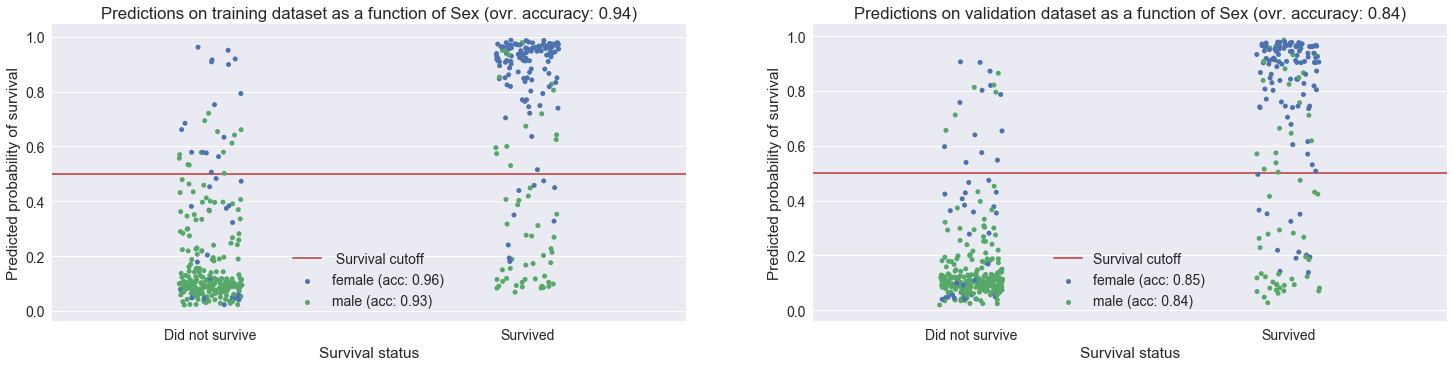

In [458]:
display_predictions(train, model = best_gb, test_size = 0.5, feature = "Sex")

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


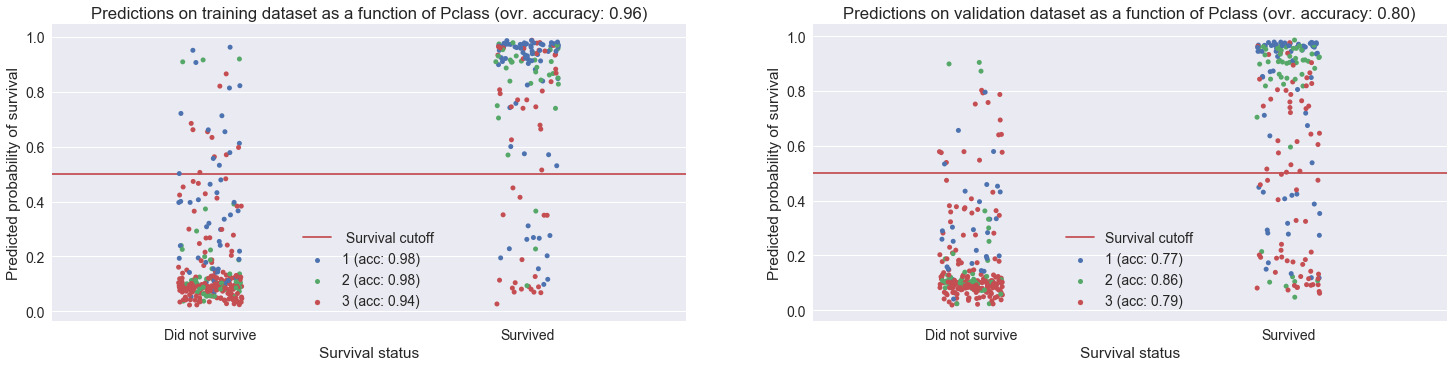

In [459]:
display_predictions(train, model = best_gb, test_size = 0.5, feature = "Pclass")

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


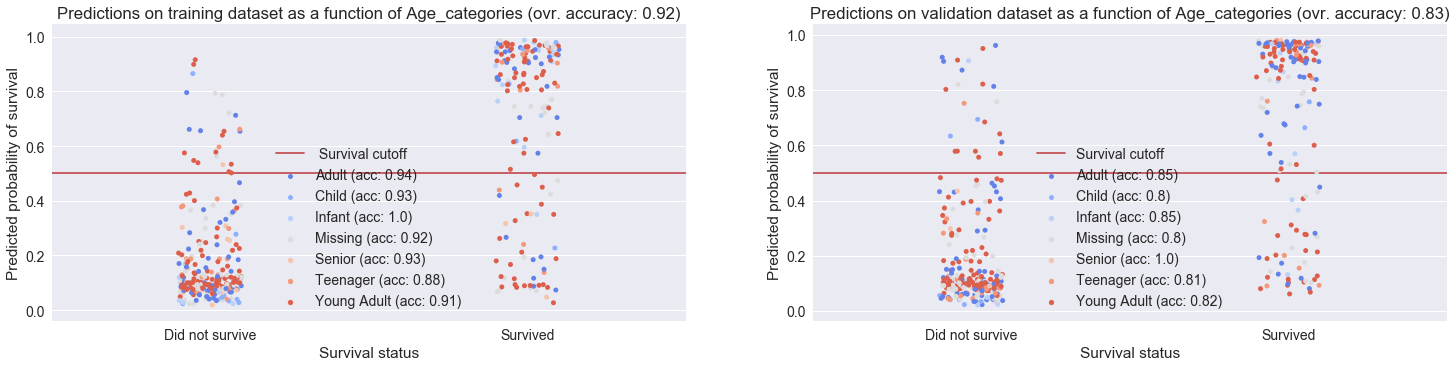

In [460]:
display_predictions(train, model = best_gb, test_size = 0.5, feature = "Age_categories")

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


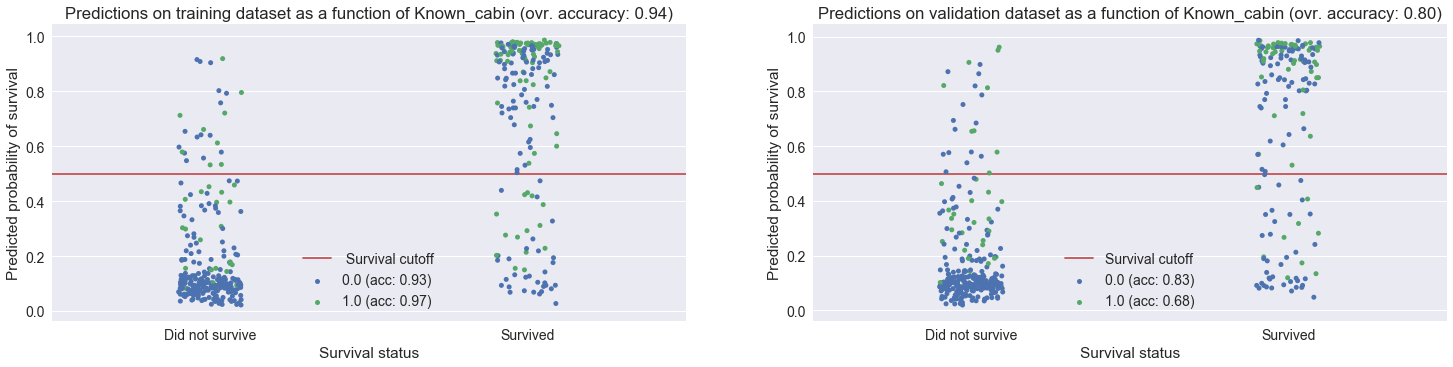

In [461]:
display_predictions(train, model = best_gb, test_size = 0.5, feature = "Known_cabin")

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


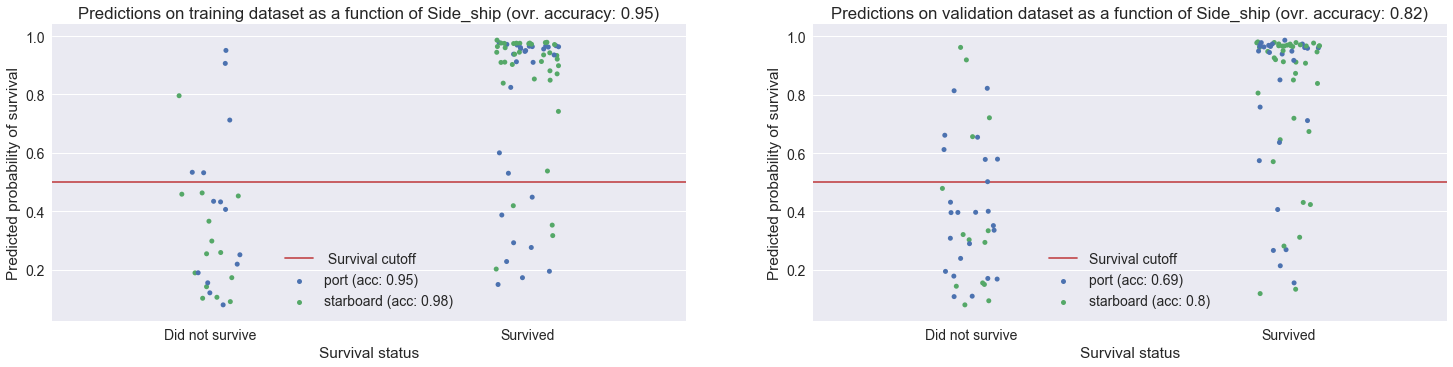

In [462]:
display_predictions(train, model = best_gb, test_size = 0.5, feature = "Side_ship")

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


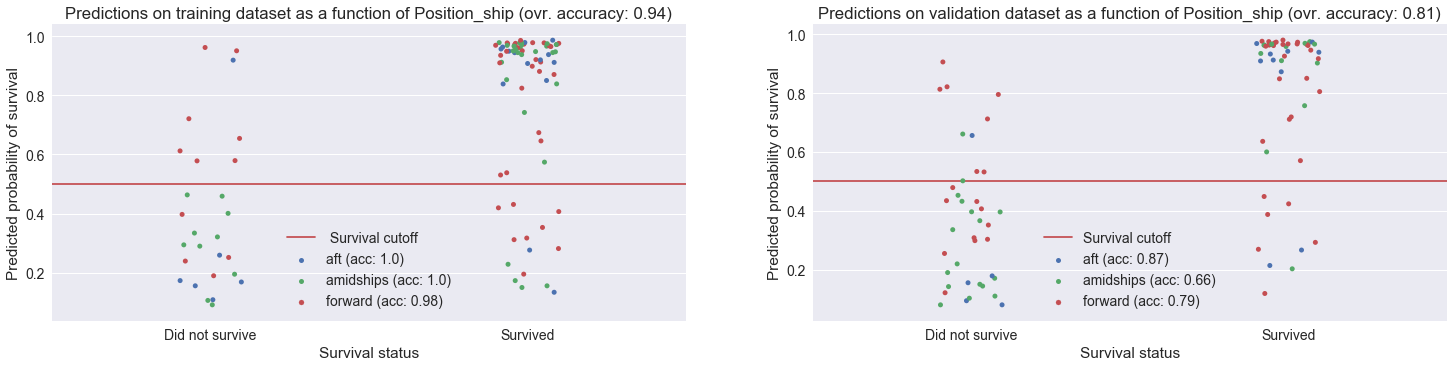

In [463]:
display_predictions(train, model = best_gb, test_size = 0.5, feature = "Position_ship")

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


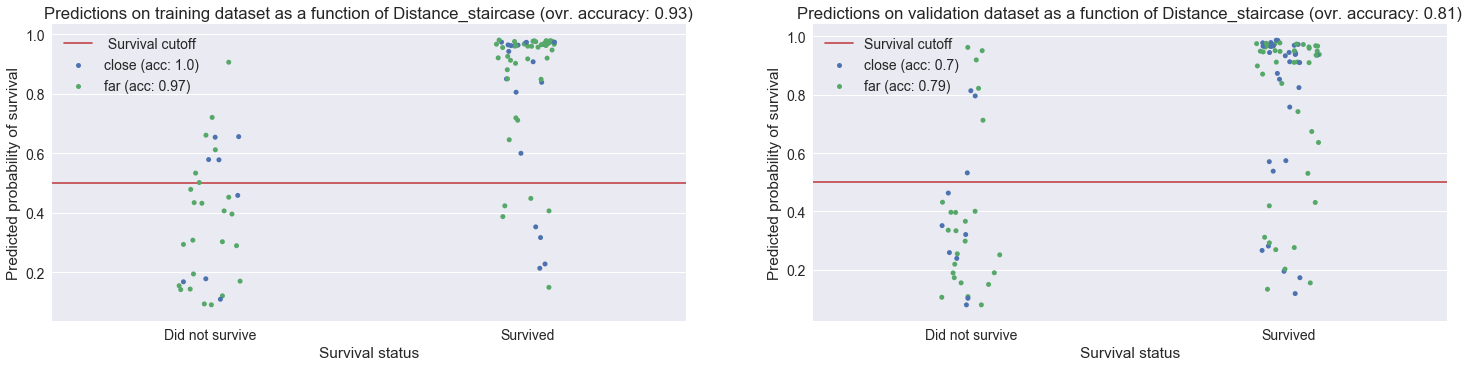

In [464]:
display_predictions(train, model = best_gb, test_size = 0.5, feature = "Distance_staircase")

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


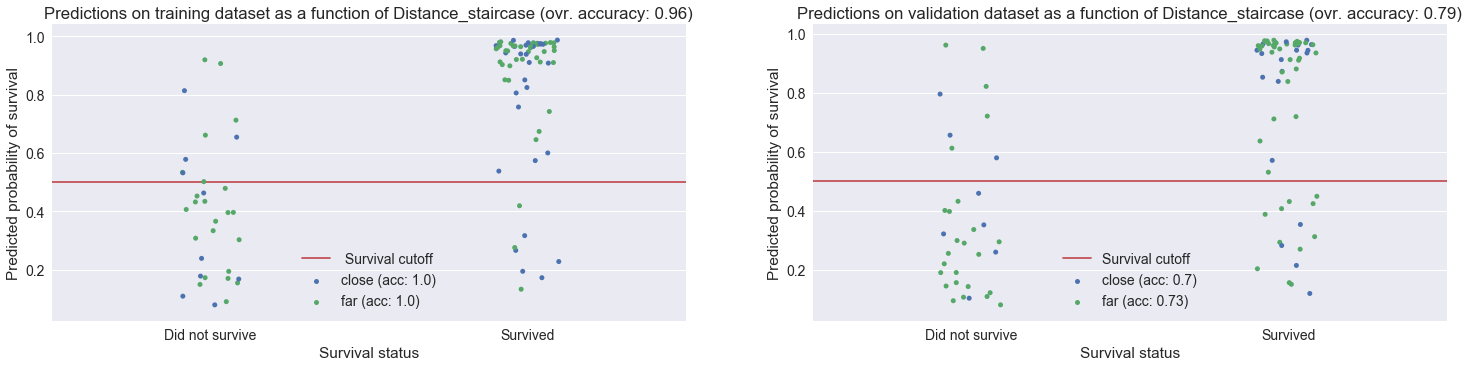

In [465]:
display_predictions(train, model = best_gb, test_size = 0.5, feature = "Distance_staircase")

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


ZeroDivisionError: division by zero

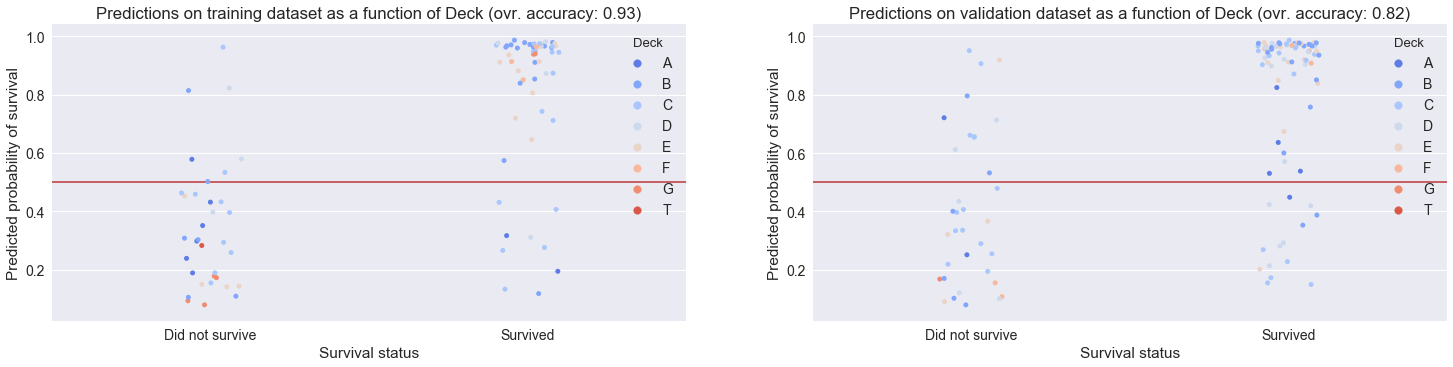

In [467]:
display_predictions(train, model = best_gb, test_size = 0.5, feature = "Deck")

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


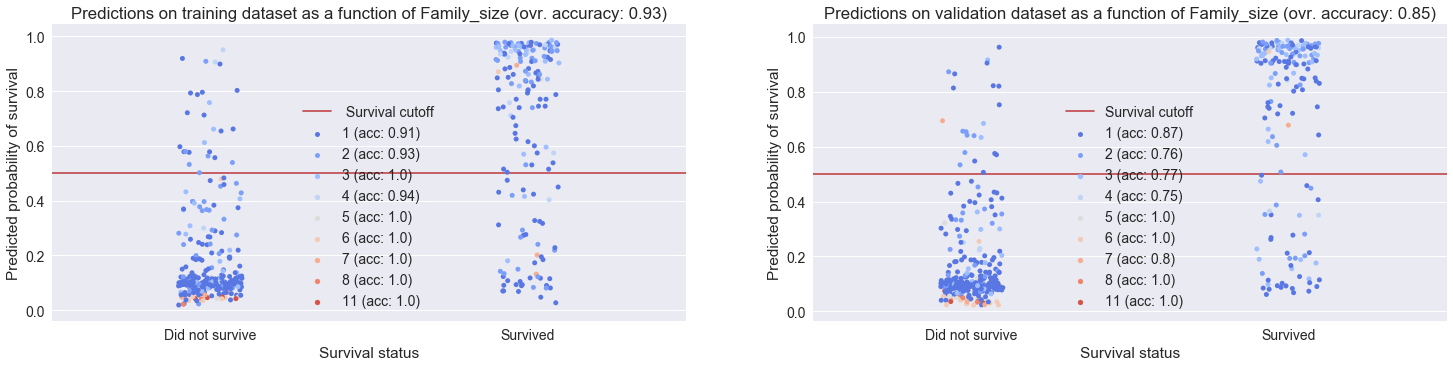

In [466]:
display_predictions(train, model = best_gb, test_size = 0.5, feature = "Family_size")